# Optional Lab: Model Evaluation and Selection

Quantifying a learning algorithm's performance and comparing different models are some of the common tasks when applying machine learning to real world applications. In this lab, you will practice doing these using the tips shared in class. Specifically, you will:

* split datasets into training, cross validation, and test sets
* evaluate regression and classification models
* add polynomial features to improve the performance of a linear regression model
* compare several neural network architectures

This lab will also help you become familiar with the code you'll see in this week's programming assignment. Let's begin!

## Imports and Lab Setup

First, you will import the packages needed for the tasks in this lab. We also included some commands to make the outputs later more readable by reducing verbosity and suppressing non-critical warnings.

In [1]:
import numpy as np
np.set_printoptions(precision = 2)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import utils

## Regression

First, you will be tasked to develop a model for a regression problem. You are given the dataset below consisting of 50 examples of an input feature `x` and its corresponding target `y`.

In [2]:
# Load the dataset from the text file
data = np.loadtxt('./data/data_w3_ex1.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x = data[:, 0]
y = data[:, 1]

# Convert 1-D arrays into 2-D because the commands later will require it
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

print(f"the shape of the inputs x is: {x.shape}")
print(f"the shape of the targets y is: {y.shape}")

the shape of the inputs x is: (50, 1)
the shape of the targets y is: (50, 1)


You can plot the dataset to get an idea of how the target behaves with respect to the input. In case you want to inspect the code, you can find the `plot_dataset()` function in the `utils.py` file outside this notebook.

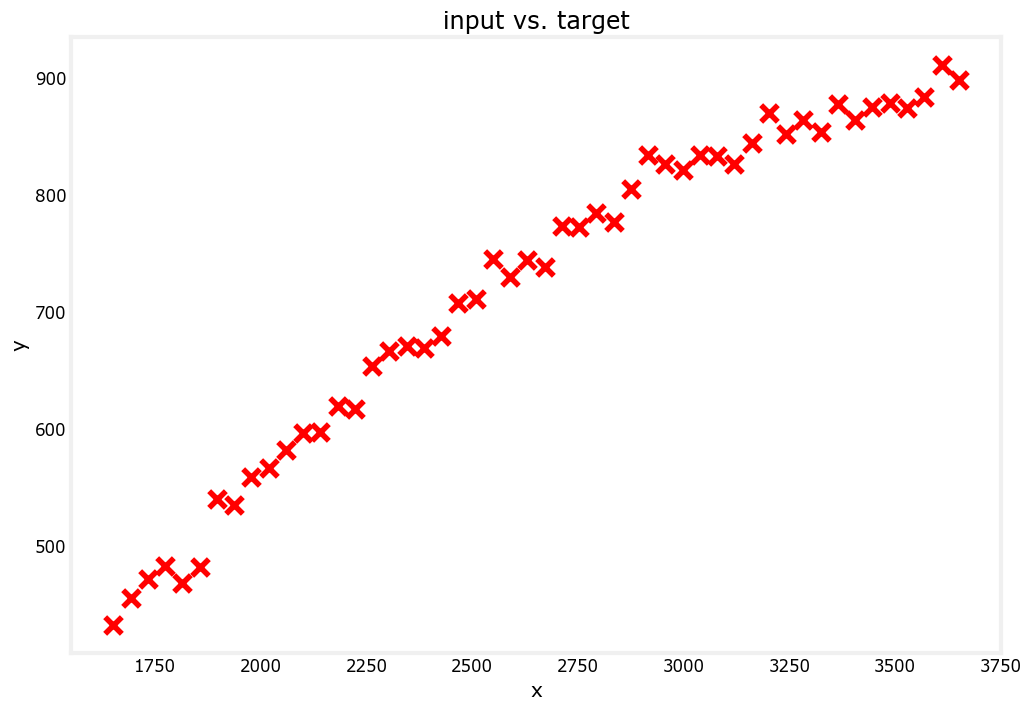

In [3]:
# Plot the entire dataset
utils.plot_dataset(x=x, y=y, title="input vs. target")

## Split the dataset into training, cross validation, and test sets

In previous labs, you might have used the entire dataset to train your models. In practice however, it is best to hold out a portion of your data to measure how well your model generalizes to new examples. This will let you know if the model has overfit to your training set.

As mentioned in the lecture, it is common to split your data into three parts:

* ***training set*** - used to train the model
* ***cross validation set (also called validation, development, or dev set)*** - used to evaluate the different model configurations you are choosing from. For example, you can use this to make a decision on what polynomial features to add to your dataset.
* ***test set*** - used to give a fair estimate of your chosen model's performance against new examples. This should not be used to make decisions while you are still developing the models.

Scikit-learn provides a [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split your data into the parts mentioned above. In the code cell below, you will split the entire dataset into 60% training, 20% cross validation, and 20% test.

In [4]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (30, 1)
the shape of the training set (target) is: (30, 1)

the shape of the cross validation set (input) is: (10, 1)
the shape of the cross validation set (target) is: (10, 1)

the shape of the test set (input) is: (10, 1)
the shape of the test set (target) is: (10, 1)


You can plot the dataset again below to see which points were used as training, cross validation, or test data.

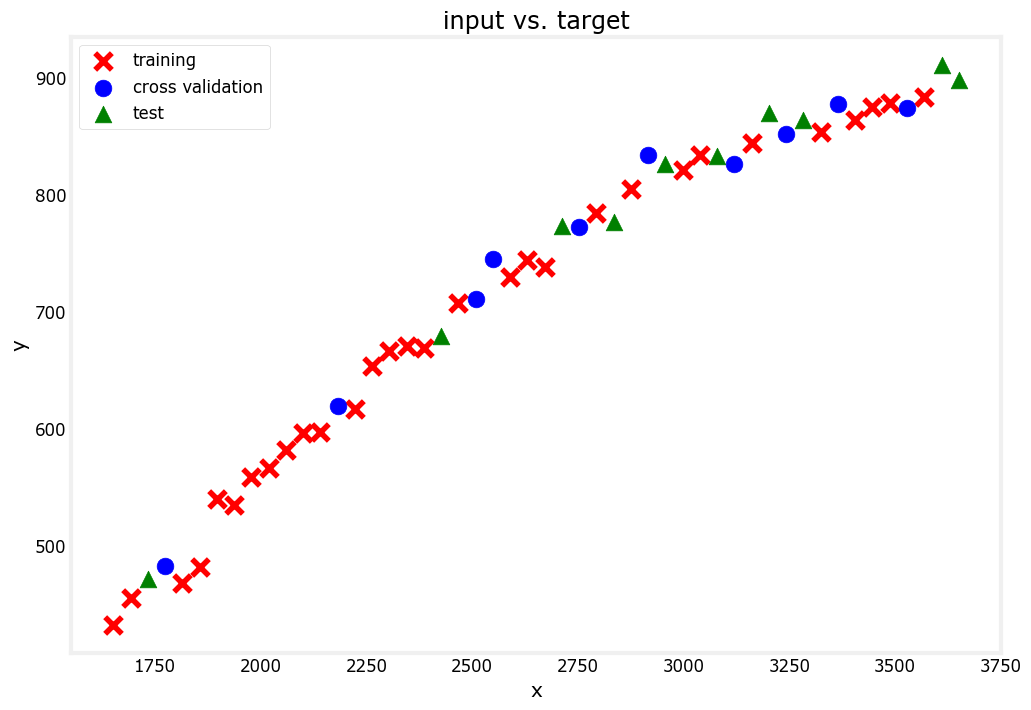

In [5]:
utils.plot_train_cv_test(x_train, y_train, x_cv, y_cv, x_test, y_test, title="input vs. target")

## Fit a linear model

Now that you have split the data, one of the first things you can try is to fit a linear model. You will do that in the next sections below.

### Feature scaling

In the previous course of this specialization, you saw that it is usually a good idea to perform feature scaling to help your model converge faster. This is especially true if your input features have widely different ranges of values. Later in this lab, you will be adding polynomial terms so your input features will indeed have different ranges. For example, $x$ runs from around 1600 to 3600, while $x^2$ will run from 2.56 million to 12.96 million. 

You will only use $x$ for this first model but it's good to practice feature scaling now so you can apply it later. For that, you will use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class from scikit-learn. This computes the z-score of your inputs. As a refresher, the z-score is given by the equation:

$$ z = \frac{x - \mu}{\sigma} $$

where $\mu$ is the mean of the feature values and $\sigma$ is the standard deviation. The code below shows how to prepare the training set using the said class. You can plot the results again to inspect if it still follows the same pattern as before. The new graph should have a reduced range of values for `x`.

Computed mean of the training set: 2504.06
Computed standard deviation of the training set: 574.85


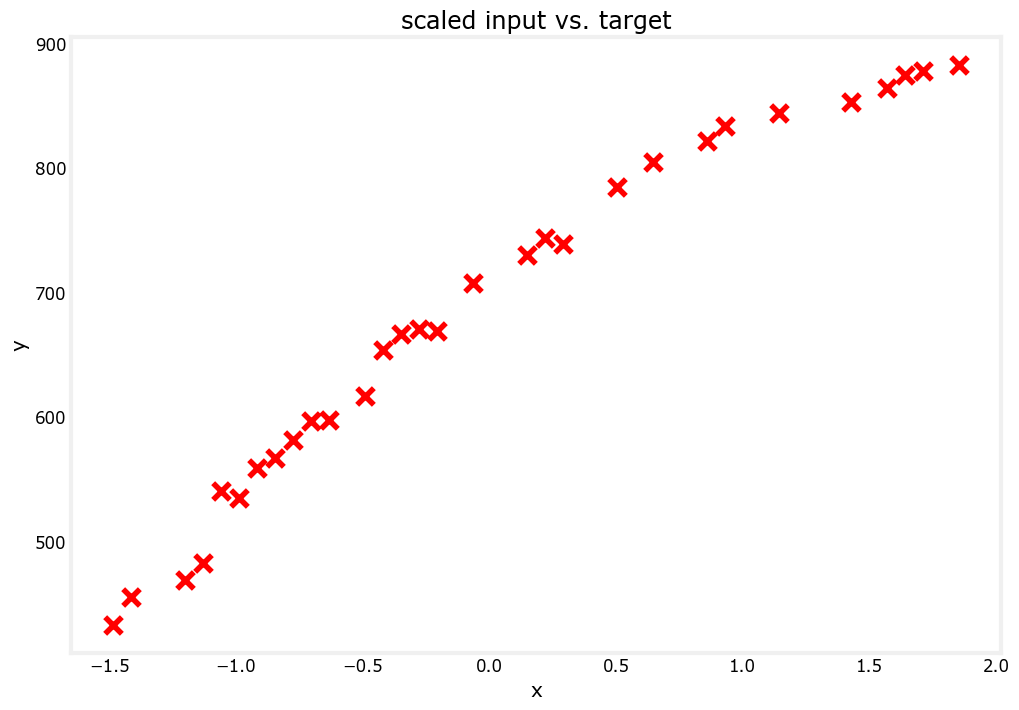

In [6]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():.2f}")

# Plot the results
utils.plot_dataset(x=X_train_scaled, y=y_train, title="scaled input vs. target")

### Train the model

Next, you will create and train a regression model. For this lab, you will use the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class but take note that there are other [linear regressors](https://scikit-learn.org/stable/modules/classes.html#classical-linear-regressors) which you can also use.

In [7]:
# Initialize the class
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train)

LinearRegression()